In [1]:
%matplotlib nbagg
import numpy as np
import json
import os, math
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import clear_output, display

from alvra_tools.load_data import *
from alvra_tools.load_meta import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *
from alvra_tools.utils import errfunc_sigma, errfunc_fwhm, threshold
import glob

In [2]:
scan_name ="RuBpyJet_scan_5"

DIR_json = "/sf/alvra/data/p18442/res/scan_info/"
DIR = "/sf/alvra/data/p18442/raw/scan_data/" + scan_name + "/"             #use this for a scan

#######################################################################

files_scan = glob.glob(DIR_json + scan_name + '.*')
scan_range = '.'+files_scan[-1].split('.')[-2]
print ('scan_range = {}'.format(scan_range))

scan_range = .run001223-001253


In [4]:
quantile_band = 0.8

channel_list = [channel_PIPS_trans, channel_PIPS_fluo, channel_Izero122, channel_position_X]

###############################################################3

json_file = DIR_json + scan_name + scan_range + ".json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 1

print ("Processing",numFiles,"files")

Signal_t = []
Signal_f = []
Izero = []
Position_mm = []

for i in range(0,numFiles):
    filename = str(data['scan_files'][i][0])
    print (filename)
    exists = os.path.isfile(filename)
    if exists: # and i !=21:
        clear_output(wait=True)
        print("step", i+1, "of",numFiles, f": Processing {filename}")
        #(data_trans_shot, data_fluo_shot, Izero_shot, laser_shot, position_shot, pulseIDs) = \
        # load_FEL_scans(filename, channel_position_X)
        
        results = load_data_compact(channel_list, filename)
        
        data_trans_shot = results[channel_PIPS_trans]
        data_fluo_shot = results[channel_PIPS_fluo]
        Izero_shot = results[channel_Izero122]
        position_shot = results[channel_position_X]
        
        data_t_shot_norm = data_trans_shot / Izero_shot
        data_f_shot_norm = data_fluo_shot / Izero_shot
        
        df_data_t = pd.DataFrame(data_t_shot_norm)
        Signal_t.append(np.nanquantile(df_data_t, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))
        
        df_data_f = pd.DataFrame(data_f_shot_norm)
        Signal_f.append(np.nanquantile(df_data_f, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))
    
        position_shot = [x for x in position_shot if (np.abs(x) > 0)]
        Position_mm.append(np.mean(position_shot))
    
Signal_t = np.asarray(Signal_t)
Signal_f = np.asarray(Signal_f)

Position_mm_readback = load_scan_readback(json_file)
Position_mm = np.asarray(Position_mm)

print ("Job done!")
print ('Quantiles for error bars: {},{}'.format(0.5 - quantile_band/2, 0.5 + quantile_band/2))

step 31 of 31 : Processing /sf/alvra/data/p18442/raw/scan_data/RuBpyJet_scan_5/run_001253.BSREAD.h5

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet           999 / 999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH1_VAL_GET          999 / 999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET          999 / 999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY         999 / 999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LTIM01-EVR0:DUMMY_PV1_NBS 999 / 999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 999 / 999 -> 0% loss

--------------------------------------------------------------------------------

FEL rep rate is 50.0 Hz
Job done!
Quantiles for error bars: 0.09999999999999998,0.9


<IPython.core.display.Javascript object>


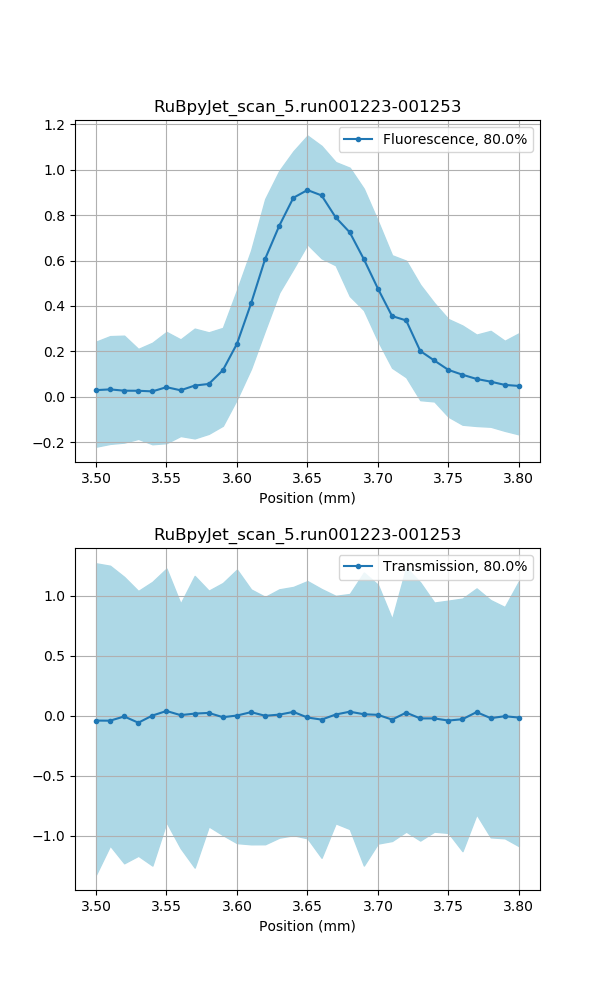

In [5]:
Int_f = Signal_f[:,0]
err_f_low = Signal_f[:,1]
err_f_high = Signal_f[:,2]
Int_t = Signal_t[:,0]
err_t_low = Signal_t[:,1]
err_t_high = Signal_t[:,2]

plt.figure(figsize = (6,10))
plt.subplots_adjust(hspace=0.25)

plt.subplot(211)
plt.plot(Position_mm, Int_f, label='Fluorescence, {}%'.format(quantile_band*100),marker='.')
plt.fill_between(Position_mm, err_f_low, err_f_high, color='lightblue')
plt.title(scan_name + scan_range)
plt.grid()
plt.xlabel("Position (mm)")
plt.legend(loc="best")

plt.subplot(212)
plt.plot(Position_mm, Int_t, label='Transmission, {}%'.format(quantile_band*100),marker='.')
plt.fill_between(Position_mm, err_t_low, err_t_high, color='lightblue')
plt.title(scan_name + scan_range)
plt.grid()
plt.xlabel("Position (mm)")
plt.legend(loc="best")


plt.show()